In [1]:
from itertools import combinations
import re
from tqdm import tqdm
import pandas as pd
import xmltodict
import networkx as nx
import pickle
import collections
import matplotlib.pyplot as plt
from unidecode import unidecode
import altair as alt
tqdm.pandas()
from collections import Counter
import string
# from genderize import Genderize
# genderize = Genderize(
#     user_agent='GenderizeDocs/0.0',
#     api_key='c363eacf807f4af4992b358200ebc15c',
#     timeout=30.0)
with open('dict_genders.pickle', 'rb') as handle:
    dict_genders = pickle.load(handle)

In [11]:
def extract_authors(dc):
    if type(dc) == list:
        result = [
            unidecode(i.get("#text").title().strip())
            for i in dc
            if i.get("#text") is not None and i.get("@scheme") != "institution"
        ]
        return [x for x in result if x != "And Others"]
    elif dc.get("#text") is not None and dc.get("@scheme") != "institution":
        return [unidecode(dc.get("#text").title().strip())]


def clean_name(name):
    if ', ' in name:
        lst = name.split(', ')
        lst = [item.split(' ')[0] for item in lst]
        return lst[1] + ' ' + lst[0]
    elif ',' in name:
        lst = name.split(',')
        lst = [item.split(' ')[0] for item in lst]
        return lst[1] + ' ' + lst[0]
    else:
        return name

def get_first_names(author_list):

    if len(author_list) > 0:
        names = []
        for x in author_list:
            words_in_name = len(x.split())

            if words_in_name > 0:
                first = re.sub(r'[^\w\s]','', x.split()[0])
            if words_in_name > 1:
                second = re.sub(r'[^\w\s]','', x.split()[1])
            if words_in_name > 2:
                third = re.sub(r'[^\w\s]','', x.split()[2])
            if words_in_name > 3:
                fourth = re.sub(r'[^\w\s]','', x.split()[3])

            if  words_in_name > 0 and len(first) > 1:
                names.append(first)
            elif words_in_name > 1 and len(second) > 1:
                names.append(second)
            elif words_in_name > 2 and len(third) > 1:
                names.append(third)
            elif words_in_name > 3 and len(fourth) > 1:
                names.append(fourth)
            else:
                names.append(x)

        return names
    else:
        return None


def name_to_gender(first_name_list):
    if first_name_list and len(first_name_list) > 0:
        return [dict_genders[name] for name in first_name_list]
    else:
        return None


def get_edges(auth_list):
    return list(combinations(auth_list, 2))

def extract_ids(dc):
    if type(dc) == list:
        return [
            i.get("#text").upper().strip()
            for i in dc
            if i.get("#text") is not None and i.get("@scheme") == "eric_accno"
        ][0]
    elif dc.get("#text") is not None and dc.get("@scheme") == "eric_accno":
        return dc.get("#text").upper().strip()
    
def extract_subject(dc):
    result = []
    for item in dc:
        if type(item) == collections.OrderedDict:
            result.append(unidecode(item.get("#text").title().strip()))
        elif type(item) == str:
            result.append(unidecode(item.title().strip()))
        else:
            result.append(unidecode(item.title().strip()))
    return result

def plot_degree_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(degrees)
    plt.show()

In [3]:
df_all = []

for year in tqdm(range(1965, 2021)):
    file_name = "data/eric" + str(year)
    with open(file_name + ".xml", encoding="utf-8") as fd:
        dict = xmltodict.parse(fd.read())
    recs = [rec["metadata"] for rec in dict["records"]["record"]]
    df = pd.DataFrame(recs)
    df = df[df['dc:type'].notna()]
    df = df[df['eric:peer_reviewed'].notna()]
    df['type'] = [''.join(map(str, l)).lower() for l in df['dc:type']]
    df = df.loc[df['eric:peer_reviewed'] == 'T']
    # df = df[['ids', 'authors', 'edges', 'dc:type', 'dc:subject', 'eric:keywords', 'eric:keywords_geo', 'dc:title', 'eric:pageCount', 'dc:date', 'eric:dateAdded']]
    df_all.append(df)

df_all = pd.concat(df_all)

df_all = df_all.loc[(df_all['type'].str.contains("journal"))]
df_all["authors"] = df_all.apply(lambda row: extract_authors(row["dc:creator"]), axis=1)
df_all = df_all[df_all['authors'].notna()] # remove nans
df_all['authors'] = df_all.apply(lambda row: [clean_name(item) for item in row['authors']], axis=1) # clean names
df_all["author_first_names"] = df_all.apply(lambda row: get_first_names(row["authors"]), axis=1) # get first names for genderize

100%|███████████████████████████████████████████| 56/56 [08:05<00:00,  8.67s/it]


In [4]:
#df_all["author_genders"] = df_all.apply(lambda row: name_to_gender(row["author_first_names"]), axis=1) # get genders from dict
df_all['n_authors'] = df_all.apply(lambda row: len(row["authors"]), axis=1)
df_all["edges"] = df_all.apply(lambda row: get_edges(sorted(row["authors"])), axis=1) # get edges
df_all["ids"] = df_all.apply(lambda row: extract_ids(row["dc:identifier"]), axis=1)

df_all = df_all[df_all['dc:subject'].notna()]
df_all["subjects"] = df_all.apply(lambda row: extract_subject(row["dc:subject"]), axis=1)
df_all.loc[:, 'subject_top'] = df_all.subjects.map(lambda x: x[0])

In [5]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 908417 entries, 17594 to 44897
Data columns (total 43 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   dcterms:accessRights       908417 non-null  object
 1   dc:subject                 908417 non-null  object
 2   dc:creator                 908417 non-null  object
 3   dc:type                    908417 non-null  object
 4   eric:keywords              398882 non-null  object
 5   eric:keywords_geo          301814 non-null  object
 6   eric:issn                  746289 non-null  object
 7   dc:language                905398 non-null  object
 8   dcterms:educationLevel     326980 non-null  object
 9   dc:description             907928 non-null  object
 10  dc:identifier              908417 non-null  object
 11  dc:title                   908417 non-null  object
 12  dc:source                  908417 non-null  object
 13  eric:citation              908372 non-nul

In [ ]:
## USE the API ##
# node_list1 = df_all["author_first_names"].tolist()
# node_list2 = [x for x in node_list1 if x is not None]  # remove none
# node_list3 = [item for sublist in node_list2 for item in sublist]
# node_list = list(set(node_list3))

# df_genders = pd.DataFrame(genderize.get(node_list))
# df_genders.to_csv("df_genders.csv", encoding='utf-8', index=False)

# dict_genders = pd.Series(df_genders.gender.values,index=df_genders.name).to_dict()
# with open('dict_genders.pickle', 'wb') as handle:
#     pickle.dump(dict_genders, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
df_gender_order = pd.DataFrame(df_all[df_all['author_genders'].notna()].author_genders.tolist(), index= df_all[df_all['author_genders'].notna()].index)

In [ ]:
df_gender_order[0].value_counts(normalize=True)

In [ ]:
df_gender_order[1].value_counts(normalize=True)

In [ ]:
df_gender_order[2].value_counts(normalize=True)

In [ ]:
df_gender_order[3].value_counts(normalize=True)

In [ ]:
df_gender_order[4].value_counts(normalize=True)

In [ ]:
def get_first_names2(author_list):

    if len(author_list) > 0:
        names = []
        for x in author_list:
            words_in_name = len(x.split())

            if words_in_name > 0:
                first = re.sub(r'[^\w\s]','', x.split()[0])
            if words_in_name > 1:
                second = re.sub(r'[^\w\s]','', x.split()[1])
            if words_in_name > 2:
                third = re.sub(r'[^\w\s]','', x.split()[2])
            if words_in_name > 3:
                fourth = re.sub(r'[^\w\s]','', x.split()[3])

            if  words_in_name > 0 and len(first) > 1:
                names.append((first, dict_genders[first]))
            elif words_in_name > 1 and len(second) > 1:
                names.append((second, dict_genders[second]))
            elif words_in_name > 2 and len(third) > 1:
                names.append((third, dict_genders[third]))
            elif words_in_name > 3 and len(fourth) > 1:
                names.append((fourth, dict_genders[fourth]))
            else:
                names.append((x, dict_genders[x]))

        return names
    else:
        return None

In [ ]:
node_list1 = df_all["authors"].tolist()
node_list2 = [x for x in node_list1 if x is not None]  # remove none
node_list3 = [item for sublist in node_list2 for item in sublist]
node_list = list(set(node_list3))
len(node_list)

In [ ]:
df_authors = pd.DataFrame(list(zip(node_list, get_first_names2(node_list))), columns = ["full_name", "tuple"])
df_authors[['first_name','gender']] = pd.DataFrame(df_authors.tuple.tolist(), index= df_authors.index)
df_authors.head()

In [ ]:
df_authors["gender"].value_counts(normalize = True, dropna=False)

In [ ]:
df_all.groupby(['eric:dateAdded'])['eric:issn'].apply(lambda x: x.isnull().mean())
# df_all["dc:subject"].iloc[328615]
#df_all[['subjects', 'subject_top']].to_csv("subjects.csv", encoding='utf-8', index=False)

In [6]:
df_all['eric:dateAdded'].value_counts().sort_index()

1971       28
1972       42
1973       36
1974       34
1975      131
1976       96
1977       81
1978       28
1979     7996
1980    15008
1981    15090
1982    12408
1983    13565
1984    13707
1985    13415
1986    13360
1987    13475
1988    12683
1989    14852
1990    14224
1991    14467
1992    14889
1993    14683
1994    16970
1995    16748
1996    16117
1997    15988
1998    14482
1999    17212
2000    17873
2001    15852
2002    18485
2003    17449
2004     6432
2005    18775
2006    18837
2007    28125
2008    35104
2009    41251
2010    37039
2011    36226
2012    35059
2013    19696
2014    37226
2015    36610
2016    38587
2017    38305
2018    35528
2019    36991
2020    37152
Name: eric:dateAdded, dtype: int64

In [7]:
def generate_graph(df_local):

    node_list1 = df_local["authors"].tolist()
    node_list2 = [x for x in node_list1 if x is not None]  # remove none
    node_list3 = [item for sublist in node_list2 for item in sublist]
    node_list = list(set(node_list3))

    n_papers_per_author = len(node_list3)/len(node_list)
    
    edge_list1 = df_local["edges"].tolist()
    edge_list2 = [x for x in edge_list1 if x is not None]  # remove none
    edge_list = [item for sublist in edge_list2 for item in sublist]

    G = nx.Graph()
    G.add_nodes_from(node_list)
    G.add_edges_from(edge_list)
    return (G, n_papers_per_author)

In [8]:
# year by year (NOT cumulative)
list1 = []

for year in tqdm(range(1965, 2021)):
    
    df_local = df_all.loc[df_all['eric:dateAdded'] == str(year)]
    
    if len(df_local) == 0:
        continue
    
    result = generate_graph(df_local)
    G = result[0]
    n_authors = len(G)
    n_papers = len(df_local)
    
    n_authors_per_paper = df_local['n_authors'].mean()
    n_papers_per_author = result[1]
    
    n_collabs = nx.number_of_edges(G)
    n_isolates = nx.number_of_isolates(G)
    mean_collabs = 2 * G.number_of_edges() / float(G.number_of_nodes())
    
    G_largest_comp = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
    largest_component = len(G_largest_comp)/len(G) 
    
    deg_assort = nx.degree_assortativity_coefficient(G)
    avg_clustering = nx.average_clustering(G)
    transitivity = nx.transitivity(G)
    
    list1.append((year, n_authors, n_papers, n_authors_per_paper, n_papers_per_author, n_collabs, n_isolates, mean_collabs, largest_component, deg_assort, avg_clustering, transitivity))

df_summary = pd.DataFrame(list1, columns = ["year", "n_authors", "n_papers", "n_authors_per_paper", "n_papers_per_author", "n_collabs", "n_isolates", "mean_collabs", "largest_component", "deg_assort", "avg_clustering", "transitivity"])
df_summary

 12%|█████▌                                      | 7/56 [01:24<02:50,  3.47s/it]/usr/local/lib/python3.9/site-packages/networkx/algorithms/assortativity/correlation.py:282: RuntimeWarning: invalid value encountered in double_scalars
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)
100%|███████████████████████████████████████████| 56/56 [16:59<00:00, 18.20s/it]


,year,n_authors,n_papers,n_authors_per_paper,n_papers_per_author,n_collabs,n_isolates,mean_collabs,largest_component,deg_assort,avg_clustering,transitivity
0,1971,35,28,1.500000,1.200000,13,12,0.742857,0.114286,-0.213333,0.000000,0.000000
1,1972,58,42,1.428571,1.034483,18,22,0.620690,0.034483,NaN,0.000000,0.000000
2,1973,47,36,1.333333,1.021277,12,23,0.510638,0.042553,NaN,0.000000,0.000000
3,1974,47,34,1.441176,1.042553,15,17,0.638298,0.042553,NaN,0.000000,0.000000
4,1975,161,131,1.358779,1.105590,44,74,0.546584,0.018634,-0.023256,0.000000,0.000000
5,1976,120,96,1.375000,1.100000,35,54,0.583333,0.033333,-0.098039,0.000000,0.000000
6,1977,103,81,1.432099,1.126214,34,38,0.660194,0.029126,-0.096774,0.000000,0.000000
7,1978,34,28,1.357143,1.117647,10,14,0.588235,0.058824,NaN,0.000000,0.000000
8,1979,8860,7996,1.247624,1.125959,1914,5197,0.432054,0.000677,0.019945,0.000000,0.000000
9,1980,15717,15008,1.264725,1.207673,3797,8707,0.483171,0.000509,-0.026748,0.000148,0.004184


In [ ]:
alt.Chart(df_summary).mark_area(
    color="lightblue",
    interpolate='step-after',
    line=True
).encode(
    x='year',
    y='n_authors'
)

In [ ]:
alt.Chart(df_summary).mark_area(
    color="lightblue",
    interpolate='step-after',
    line=True
).encode(
    x='year',
    y='n_papers'
)

In [ ]:
alt.Chart(df_summary).mark_area(
    color="lightblue",
    interpolate='step-after',
    line=True
).encode(
    x='year',
    y='n_authors_per_paper'
)

In [ ]:
alt.Chart(df_summary).mark_area(
    color="lightblue",
    interpolate='step-after',
    line=True
).encode(
    x='year',
    y='n_papers_per_author'
)

In [ ]:
alt.Chart(df_summary).mark_area(
    color="lightblue",
    interpolate='step-after',
    line=True
).encode(
    x='year',
    y='n_collabs'
)

In [ ]:
alt.Chart(df_summary).mark_area(
    color="lightblue",
    interpolate='step-after',
    line=True
).encode(
    x='year',
    y='mean_collabs'
)

In [ ]:
alt.Chart(df_summary).mark_area(
    color="lightblue",
    interpolate='step-after',
    line=True
).encode(
    x='year',
    y='n_isolates'
)

In [ ]:
alt.Chart(df_summary).mark_area(
    color="lightblue",
    interpolate='step-after',
    line=True
).encode(
    x='year',
    y='largest_component'
)

In [ ]:
alt.Chart(df_summary).mark_area(
    color="lightblue",
    interpolate='step-after',
    line=True
).encode(
    x='year',
    y='deg_assort'
)

In [ ]:
alt.Chart(df_summary).mark_area(
    color="lightblue",
    interpolate='step-after',
    line=True
).encode(
    x='year',
    y='avg_clustering'
)

In [ ]:
alt.Chart(df_summary).mark_area(
    color="lightblue",
    interpolate='step-after',
    line=True
).encode(
    x='year',
    y='transitivity'
)

In [9]:
list1 = []

result = generate_graph(df_all)
G = result[0]
n_authors = len(G)
n_papers = len(df_all)

n_authors_per_paper = df_all['n_authors'].mean()
n_papers_per_author = result[1]

n_collabs = nx.number_of_edges(G)
n_isolates = nx.number_of_isolates(G)
mean_collabs = 2 * G.number_of_edges() / float(G.number_of_nodes())

G_largest_comp = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
largest_component = len(G_largest_comp)/len(G) 

deg_assort = nx.degree_assortativity_coefficient(G)
avg_clustering = nx.average_clustering(G)
transitivity = nx.transitivity(G)

list1.append((year, n_authors, n_papers, n_authors_per_paper, n_papers_per_author, n_collabs, n_isolates, mean_collabs, largest_component, deg_assort, avg_clustering, transitivity))

df_overall = pd.DataFrame(list1, columns = ["year", "n_authors", "n_papers", "n_authors_per_paper", "n_papers_per_author", "n_collabs", "n_isolates", "mean_collabs", "largest_component", "deg_assort", "avg_clustering", "transitivity"])
df_overall

,year,n_authors,n_papers,n_authors_per_paper,n_papers_per_author,n_collabs,n_isolates,mean_collabs,largest_component,deg_assort,avg_clustering,transitivity
0,2020,697445,908417,2.027529,2.640842,1545698,115526,4.432458,0.635168,0.210728,0.464084,0.302958


In [10]:
nx.info(G)

'Graph with 697445 nodes and 1545698 edges'

In [ ]:
plt.figure(figsize=(12,12))

def draw_ego(name):
    hub_ego = nx.ego_graph(G, name)
    pos = nx.spring_layout(hub_ego)
    nx.draw(hub_ego, pos, node_color="b", node_size=50, with_labels=True)
    options = {"node_size": 300, "node_color": "r"}
    nx.draw_networkx_nodes(hub_ego, pos, nodelist=[name], **options)

draw_ego("Linda Darling-Hammond")

In [ ]:
#df_summary.to_csv("df_summary.csv", encoding='utf-8', index=False)

In [ ]:
names = []

for x in tqdm(G.nodes()):
    words_in_name = len(x.split())
    
    if words_in_name > 0:
        first = re.sub(r'[^\w\s]','', x.split()[0])
    if words_in_name > 1:
        second = re.sub(r'[^\w\s]','', x.split()[1])
    if words_in_name > 2:
        third = re.sub(r'[^\w\s]','', x.split()[2])
    
    if  words_in_name > 0 and len(first) > 1:
        names.append(first)
    elif words_in_name > 1 and len(second) > 1:
        names.append(second)
    elif words_in_name > 2 and len(third) > 1:
        names.append(third)

Counter(names).most_common()

In [ ]:
len(set(names))

In [ ]:
nx.effective_size(G)

Text(0.5, 1.0, 'Wikipedia Degree Distribution')

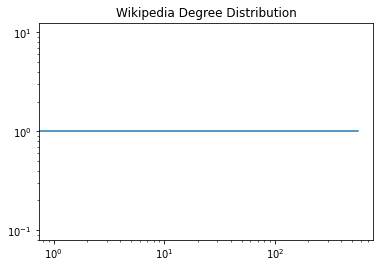

In [17]:
degs = {}
for n in G.nodes() :
    deg = G.degree(n)
    if deg not in degs:
        degs[deg] = 0
        degs[deg] += 1
items = sorted(degs.items())
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot([k for (k, v) in items] , [v for (k, v) in items])
ax.set_xscale('log')
ax.set_yscale('log')
plt.title("Wikipedia Degree Distribution")